In [57]:
import pandas as pd
import geopandas as gpd
import acbm
from pam.read import load_travel_diary
from pam import write

from shapely import wkt, Point

from acbm.postprocessing.matsim import (
    # add_home_location_to_individuals,
    # calculate_percentage_remaining,
    # filter_by_pid,
    # filter_no_location,
    # log_row_count,
    get_passengers,
    get_pt_subscription,
    get_students,
    get_hhlIncome,
)


This notebook shows how to save acbm output as matsim xml files using PAM. A number of preprocessing steps need to be done befehand
Ideally, some of these should be fixed upstream in the acbm code. Some may be the result of NTS data issues.

# Read the data

In [2]:
# path to the data
individuals = pd.read_csv(acbm.root_path / "data/processed/activities_pam/people.csv")
households = pd.read_csv(acbm.root_path / "data/processed/activities_pam/households.csv")
activities = pd.read_csv(acbm.root_path / "data/processed/activities_pam/activities.csv")
legs = pd.read_csv(acbm.root_path / "data/processed/activities_pam/legs.csv")
legs_geo = pd.read_parquet(acbm.root_path / "data/processed/activities_pam/legs_with_locations.parquet")

In [3]:
individuals.head(5)

,pid,hid,freq,hzone,age_years
0,199,89,NaN,E02002330,39
1,200,89,NaN,E02002330,38
2,312,139,NaN,E02002330,64
3,610,283,NaN,E02002330,67
4,611,283,NaN,E02002330,64


In [4]:
 # rename age_years to age in individuals
individuals.rename(columns={"age_years": "age"}, inplace=True)


In [5]:
spc_with_nts = pd.read_parquet(acbm.root_path / "data/interim/matching/spc_with_nts_trips.parquet")
spc_with_nts.head(5)

,id,household,age_years,OA11CD,nts_hh_id,nts_ind_id,education_type,TripID,TravDay,seq,mode,oact,dact,tst,tet,TripDisIncSW,TripTotalTime,IndividualID
0,199,89,39,E00059031,2.019001e+09,2019001326,education_university,2.019018e+09,3.0,1.0,car,home,shop,540.0,555.0,2.0,15.0,2.019001e+09
1,199,89,39,E00059031,2.019001e+09,2019001326,education_university,2.019018e+09,4.0,1.0,car_passenger,home,other,450.0,480.0,20.0,30.0,2.019001e+09
2,199,89,39,E00059031,2.019001e+09,2019001326,education_university,2.019018e+09,2.0,2.0,car,work,home,960.0,1020.0,25.0,60.0,2.019001e+09
3,199,89,39,E00059031,2.019001e+09,2019001326,education_university,2.019018e+09,4.0,3.0,car,home,shop,960.0,975.0,2.0,15.0,2.019001e+09
4,199,89,39,E00059031,2.019001e+09,2019001326,education_university,2.019018e+09,7.0,2.0,car,work,home,1005.0,1065.0,25.0,60.0,2.019001e+09


In [6]:
spc = pd.read_parquet(acbm.root_path / "data/external/spc_output/leeds_people_hh.parquet")
spc

,id,household,workplace,events,weekday_diaries,weekend_diaries,orig_pid,id_tus_hh,id_tus_p,pid_hs,...,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8_household
0,0,0,NaN,"{'concert_f': 3.6287833784528047e-16, 'concert...","[954, 1037, 1234, 2981, 6290, 9535, 10385, 106...","[955, 1036, 1235, 2980, 6291, 9536, 10384, 106...",E02002330_0001_001,34051017,1,2911721,...,2.0,NaN,6.0,True,2.0,2,1,68,1,1.0
1,1,0,NaN,"{'concert_f': 9.903925281880971e-14, 'concert_...","[3435, 6069, 13203, 14704]","[3436, 6068, 13202, 14703]",E02002330_0001_002,21040818,1,2904618,...,2.0,NaN,6.0,True,2.0,2,2,65,1,6.0
2,2,1,NaN,"{'concert_f': 1.2791347489984115e-31, 'concert...","[762, 5168, 6201, 8977]","[761, 5169, 6200, 8976]",E02002330_0002_001,11131017,1,2902311,...,1.0,NaN,5.0,True,1.0,2,1,86,1,2.0
3,3,2,NaN,"{'concert_f': 7.754311082130982e-10, 'concert_...","[1580, 5417, 5956, 12901]","[1581, 5416, 5957, 12900]",E02002330_0003_001,15020311,1,2911131,...,1.0,NaN,6.0,True,2.0,1,1,58,1,4.0
4,4,2,508.0,"{'concert_f': 2.1388457227544677e-08, 'concert...","[318, 3145, 10496, 12819, 13943]","[319, 3144, 10495, 12818, 13942]",E02002330_0003_002,20090607,1,2909582,...,1.0,NaN,6.0,True,2.0,1,2,56,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794634,794634,334848,NaN,"{'concert_f': 0.030085181817412376, 'concert_f...","[253, 904, 960, 1258, 1666, 1827, 2990, 3158, ...","[252, 903, 961, 1259, 1667, 1826, 2991, 3159, ...",E02006876_3658_001,15171109,2,2910202,...,3.0,NaN,6.0,True,1.0,1,1,39,1,3.0
794635,794635,334849,NaN,"{'concert_f': 5.36953439222998e-06, 'concert_f...","[1611, 2074, 3331, 3973, 5305, 7241, 9500, 10413]","[1610, 2075, 3330, 3974, 5304, 7240, 9499, 10412]",E02006876_3659_001,12080913,2,2903691,...,2.0,NaN,5.0,False,1.0,0,2,51,1,7.0
794636,794636,334850,NaN,"{'concert_f': 9.81540181321244e-28, 'concert_f...","[1768, 1833, 2004, 3538, 5690, 5693, 9177, 112...","[1767, 1832, 2005, 3537, 5691, 5692, 9176, 112...",E02006876_3660_001,15291209,1,2905917,...,4.0,NaN,2.0,True,5.0,0,1,82,1,NaN
794637,794637,334851,NaN,"{'concert_f': 0.05208142101764679, 'concert_fs...","[2173, 14404, 15340, 16376]","[2174, 14403, 15339, 16377]",E02006876_3661_001,20280416,1,2907191,...,4.0,NaN,3.0,True,5.0,0,1,38,1,2.0


In [7]:
# add sex column to individuals

spc = pd.read_parquet(acbm.root_path / "data/external/spc_output/leeds_people_hh.parquet", 
                      columns=["id", "household", "age_years", "sex", "salary_yearly"])
spc.head(5)

# change spc["sex"] column: 1 = male, 2 = female

spc["sex"] = spc["sex"].map({1:'male',
                             2: 'female'})

spc.head(5)

,id,household,age_years,sex,salary_yearly
0,0,0,68,male,NaN
1,1,0,65,female,NaN
2,2,1,86,male,NaN
3,3,2,58,male,NaN
4,4,2,56,female,36646.464844


In [8]:
individuals = individuals.merge(spc[["id", "sex"]], left_on="pid", right_on="id", how="left")
individuals = individuals.drop(columns="id")
individuals.head(5)

,pid,hid,freq,hzone,age,sex
0,199,89,NaN,E02002330,39,male
1,200,89,NaN,E02002330,38,female
2,312,139,NaN,E02002330,64,female
3,610,283,NaN,E02002330,67,female
4,611,283,NaN,E02002330,64,male


In [9]:
individuals = get_passengers(
    legs = legs, 
    individuals = individuals, 
    modes = ['car_passenger', 'taxi'])


In [10]:
individuals = get_pt_subscription(individuals = individuals, age_threshold = 66)

In [11]:
individuals = get_students(
    individuals = individuals,
    activities = activities,
    age_base_threshold = 16,
    #age_upper_threshold = 30,
    activity = 'education')

individuals.head(10)


,pid,hid,freq,hzone,age,sex,isPassenger,hasPTSubscription,isStudent
0,199,89,NaN,E02002330,39,male,False,False,False
1,200,89,NaN,E02002330,38,female,True,False,False
2,312,139,NaN,E02002330,64,female,False,False,False
3,610,283,NaN,E02002330,67,female,True,True,False
4,611,283,NaN,E02002330,64,male,False,False,False
5,612,283,NaN,E02002330,8,male,True,False,True
6,613,283,NaN,E02002330,2,female,True,False,True
7,2016,892,NaN,E02002330,49,male,True,False,False
8,2017,892,NaN,E02002330,48,female,False,False,False
9,2018,892,NaN,E02002330,9,male,True,False,True


<Axes: xlabel='age'>

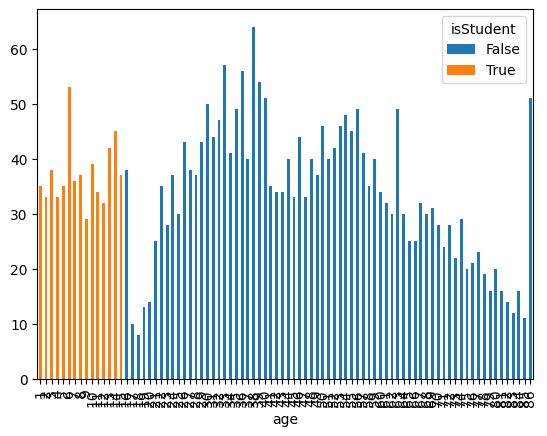

In [12]:
# histogram of x by age and isStudent 
individuals.groupby(['age', 'isStudent']).size().unstack().plot(kind='bar', stacked=True)


In [13]:
individuals = get_hhlIncome(
        individuals = individuals,
        individuals_with_salary = spc,
        pension_age = 66,
        pension = 13000)

individuals.head(10)

,pid,hid,freq,hzone,age,sex,isPassenger,hasPTSubscription,isStudent,hhlIncome
0,199,89,NaN,E02002330,39,male,False,False,False,34167.0
1,200,89,NaN,E02002330,38,female,True,False,False,34167.0
2,312,139,NaN,E02002330,64,female,False,False,False,22677.0
3,610,283,NaN,E02002330,67,female,True,True,False,13000.0
4,611,283,NaN,E02002330,64,male,False,False,False,13000.0
5,612,283,NaN,E02002330,8,male,True,False,True,13000.0
6,613,283,NaN,E02002330,2,female,True,False,True,13000.0
7,2016,892,NaN,E02002330,49,male,True,False,False,66666.0
8,2017,892,NaN,E02002330,48,female,False,False,False,66666.0
9,2018,892,NaN,E02002330,9,male,True,False,True,66666.0


### Add attributes to do with vehicle ownership 

These attributes are in the nts dataset. We will merge them onto the processed dataset
#TODO: move this upstream so that it is part of the individuals.csv output

In [76]:
nts_individuals = pd.read_parquet(acbm.root_path / "data/external/nts/filtered/nts_individuals.parquet")


#### Create a df with the vehicle ownership data (from the nts)

In [79]:
nts_individuals = nts_individuals[["IndividualID", "OwnCycleN_B01ID", "DrivLic_B02ID", "CarAccess_B01ID"]]

# Create CarAvailability colum

car_availability_mapping = {
    1: "yes", # Main driver of company car
    2: "yes", # Other main driver
    3: "some", # Not main driver of household car
    }

nts_individuals['CarAvailability'] = nts_individuals['CarAccess_B01ID'].map(car_availability_mapping).fillna('no')
# Create BicycleAvailability column

bicycle_availability_mapping = {
    1: "yes", # Own a pedal cycle yourself
    2: "some", # Have use of household pedal cycle
    3: "no", # Have use of non-household pedal cycle
    }

nts_individuals['BicycleAvailability'] = nts_individuals['OwnCycleN_B01ID'].map(bicycle_availability_mapping).fillna('no')

# Create hasLicence column
# 1: Full licence, 2: Provisional licence, 3: Other or none
nts_individuals["hasLicence"] = nts_individuals["DrivLic_B02ID"].apply(lambda x: x == 1)

# Keep only the columns we created
nts_individuals = nts_individuals[["IndividualID", "CarAvailability", "BicycleAvailability", "hasLicence"]]
nts_individuals.head(10)


,IndividualID,CarAvailability,BicycleAvailability,hasLicence
0,2019002187,yes,yes,True
1,2019002187,yes,yes,True
2,2019002187,yes,yes,True
3,2019002187,yes,yes,True
4,2019002187,yes,yes,True
5,2019002187,yes,yes,True
6,2019002187,yes,yes,True
7,2019002187,yes,yes,True
8,2019002187,yes,yes,True
9,2019002187,yes,yes,True


### Merge the data onto the individuals df

In [ ]:
# get spc id from spc_with_nts
nts_individuals = nts_individuals.merge(
    spc_with_nts[["id", "nts_ind_id"]], 
    left_on='IndividualID',
    right_on='nts_ind_id', 
    how='inner').drop(columns=['nts_ind_id'])

nts_individuals.rename(columns={"id": "spc_id"}, inplace=True)
nts_individuals.head(10)

# merge vehicle ownership data onto individuals
individuals = individuals.merge(
    nts_individuals, 
    left_on="pid", 
    right_on="spc_id", 
    how="left").drop(columns= ["spc_id", "IndividualID"])

individuals.head(10)



,pid,hid,freq,hzone,age,sex,isPassenger,hasPTSubscription,isStudent,hhlIncome,CarAvailability,BicycleAvailability,hasLicence
0,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
1,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
2,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
3,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
4,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
5,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
6,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
7,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
8,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True
9,199,89,NaN,E02002330,39,male,False,False,False,34167.0,yes,yes,True


# Clean the data

In [14]:
# We will be removing some rows in each planning operation. This function helps keep a 
# record of the number of rows in each table after each operation.

row_counts = []

# # Function to log row counts
def log_row_count(df, name, operation):
    row_counts.append((operation, name, len(df)))


### Record number of rows

In [ ]:
log_row_count(individuals, "individuals", "0_initial")
log_row_count(households, "households", "0_initial")
log_row_count(activities, "activities", "0_initial")
log_row_count(legs, "legs", "0_initial")
log_row_count(legs_geo, "legs_geo", "0_initial")

In [ ]:
row_counts

## Remove people that don't exist across all datasets

When writing to matsim using pam, we get an error when a pid exists in one dataset but not in the other. We will remove these people from the datasets.

In [ ]:
def filter_by_pid(individuals, activities, legs, legs_geo, households):
    """
    Filter the input DataFrames to include only include people (pids) that exist in all
    dfs 

    Parameters
    ----------
    individuals: pd.DataFrame
        Individuals DataFrame.
    activities: pd.DataFrame
        Activities DataFrame.
    legs: pd.DataFrame: 
        Legs DataFrame.
    legs_geo: pd.DataFrame
        Legs with geo DataFrame.
    households: pd.DataFrame
        Households DataFrame.

    Returns
    -------
    tuple
        A tuple containing the filtered DataFrames (individuals, activities, legs, legs_geo, households).
    """
    # Identify common pids
    common_pids = set(individuals["pid"]).intersection(activities["pid"]).intersection(legs["pid"]).intersection(legs_geo["pid"])

    # Filter Individual Level DataFrames
    individuals = individuals[individuals["pid"].isin(common_pids)]
    activities = activities[activities["pid"].isin(common_pids)]
    legs = legs[legs["pid"].isin(common_pids)]
    legs_geo = legs_geo[legs_geo["pid"].isin(common_pids)]

    # Filter Household Level DataFrame
    households = households[households["hid"].isin(individuals["hid"])]

    return individuals, activities, legs, legs_geo, households

# Apply
individuals, activities, legs, legs_geo, households = filter_by_pid(individuals, activities, legs, legs_geo, households)

In [ ]:
log_row_count(individuals, "individuals", "1_filter_by_pid")
log_row_count(households, "households", "1_filter_by_pid")
log_row_count(activities, "activities", "1_filter_by_pid")
log_row_count(legs, "legs", "1_filter_by_pid")
log_row_count(legs_geo, "legs_geo", "1_filter_by_pid")

In [ ]:
row_counts

In [ ]:
sorted(row_counts, key=lambda x: x[0])

In [ ]:
# all rows where start_location_geometry_wkt is null
legs_geo[legs_geo['start_location_geometry_wkt'].isnull()]

# all rows where end_location_geometry_wkt is null
#legs_geo[legs_geo['end_location_geometry_wkt'].isnull()]

## Rename columns for PAM

In [ ]:
# TODO rename in 3.3_assign_facility_all script
# rename start_location_geometry_wkt and end_location_geometry_wkt to start_loc and end_loc
legs_geo.rename(columns={"start_location_geometry_wkt": "start_loc", "end_location_geometry_wkt": "end_loc"}, inplace=True)
legs_geo


## Remove people with missing locations

In [ ]:
def filter_no_location(individuals, households, activities, legs, legs_geo):
    """
    Cleans the provided DataFrames by removing rows without location data. Gets all pids
    that have at least one row with missing location data, and removes all rows with 
    these pids. pids are geneerated from two sources: 
       - legs_geo with missing start_loc or end_loc
       - individuals with missing hzone 

    Parameters
    ----------
    individuals : pd.DataFrame
        DataFrame containing individual data.
    households : pd.DataFrame
        DataFrame containing household data.
    activities : pd.DataFrame
        DataFrame containing activity data.
    legs : pd.DataFrame
        DataFrame containing legs data.
    legs_geo : pd.DataFrame
        DataFrame containing legs with geographic data.

    Returns
    -------
    tuple
        A tuple containing the cleaned DataFrames (individuals_cleaned, households_cleaned, activities_cleaned, legs_cleaned, legs_geo_cleaned).
    """
    # Identify rows in legs_geo where start_loc or end_loc are null
    invalid_rows_legs_geo = legs_geo[legs_geo["start_loc"].isnull() | legs_geo["end_loc"].isnull()]

    # Extract the pid values associated with these rows
    invalid_pids_legs_geo = invalid_rows_legs_geo["pid"].unique()

    # Identify rows in individuals where hzone is null
    invalid_rows_individuals = individuals[individuals["hzone"].isnull()]

    # Extract the pid values associated with these rows
    invalid_pids_individuals = invalid_rows_individuals["pid"].unique()

    # Combine the invalid pid values from both sources
    invalid_pids = set(invalid_pids_legs_geo).union(set(invalid_pids_individuals))

    # Remove rows with these pids from all DataFrames
    individuals_cleaned = individuals[~individuals["pid"].isin(invalid_pids)]
    activities_cleaned = activities[~activities["pid"].isin(invalid_pids)]
    legs_cleaned = legs[~legs["pid"].isin(invalid_pids)]
    legs_geo_cleaned = legs_geo[~legs_geo["pid"].isin(invalid_pids)]

    # Extract remaining hid values from individuals_cleaned
    remaining_hids = individuals_cleaned["hid"].unique()

    # Filter households_cleaned to only include rows with hid values in remaining_hids
    households_cleaned = households[households["hid"].isin(remaining_hids)]

    return individuals_cleaned, households_cleaned, activities_cleaned, legs_cleaned, legs_geo_cleaned

# Apply
individuals, households, activities, legs, legs_geo = filter_no_location(individuals, 
                                                                         households, 
                                                                         activities, 
                                                                         legs, 
                                                                         legs_geo)



In [ ]:
log_row_count(individuals, "individuals", "2_filter_no_location")
log_row_count(households, "households", "2_filter_no_location")
log_row_count(activities, "activities", "2_filter_no_location")
log_row_count(legs, "legs", "2_filter_no_location")
log_row_count(legs_geo, "legs_geo", "2_filter_no_location")


In [ ]:
row_counts

In [ ]:
def calculate_percentage_remaining(row_counts):
    """
    Calculate the percentage of rows remaining for each DataFrame based on the initial counts.

    Parameters
    ----------
    row_counts : list of tuples
        List of tuples containing stage, DataFrame names, and their row counts.

    Returns
    -------
    list of tuples
        List of tuples containing stage, DataFrame names, and their percentage of rows remaining.
    """
    # Extract initial counts
    initial_counts = {df_name: count for stage, df_name, count in row_counts if stage == '0_initial'}

    # Calculate percentage remaining
    percentage_remaining = []
    for stage, df_name, count in row_counts:
        if df_name in initial_counts:
            initial_count = initial_counts[df_name]
            percentage = round((count / initial_count) * 100, 1)
            percentage_remaining.append((stage, df_name, count, percentage))

    # Sort by df_name
    percentage_remaining.sort(key=lambda x: x[1])

    return percentage_remaining


percentages = calculate_percentage_remaining(row_counts)

# Print the percentages
for stage, df_name, count, percentage in percentages:
    print(f"{stage} - {df_name} - {count} rows: {percentage:.1f}% rows remaining")

# # Log the percentages
# for stage, df_name, count, percentage in percentages:
#     logging.info(f"{stage} - {df_name} - {count} rows: {percentage:.1f}% rows remaining")

## Convert to point 

In [ ]:
# Function to convert to Point if not already a Point
def convert_to_point(value):
    if isinstance(value, Point):
        return value
    return wkt.loads(value)

# Convert start_loc and end_loc to shapely point objects
legs_geo["start_loc"] = legs_geo["start_loc"].apply(convert_to_point)
legs_geo["end_loc"] = legs_geo["end_loc"].apply(convert_to_point)

# Verify the type of the first element in the 'start_loc' column
print(type(legs_geo['start_loc'].iloc[0]))  # Should be <class 'shapely.geometry.point.Point'>

# Convert to GeoDataFrame with start_loc as the active geometry
legs_geo = gpd.GeoDataFrame(legs_geo, geometry='start_loc')


## Add home location to individuals 

In [ ]:
def add_home_location_to_individuals(legs_geo, individuals):
    """
    Adds home location to individuals dataframe. Location is obtained 
    from legs_geo (rows with orign activity = home) 

    Parameters
    ----------
    legs_geo : pd.DataFrame
        DataFrame containing legs with geographic data.
    individuals : pd.DataFrame
        DataFrame containing individual data.

    Returns
    -------
    pd.DataFrame
        The modified individuals DataFrame with location information.
    """
    # Filter by origin activity = home
    legs_geo_home = legs_geo[legs_geo["origin activity"] == "home"]
    
    # Get one row for each hid group
    legs_geo_home = legs_geo_home.groupby("hid").first().reset_index()
    
    # Keep only the columns we need: hid and start_location
    legs_geo_home = legs_geo_home[["hid", "start_loc"]]
    
    # Rename start_loc to loc
    legs_geo_home.rename(columns={"start_loc": "loc"}, inplace=True)
    
    # Merge legs_geo_home with individuals
    individuals_geo = individuals.copy()
    individuals_geo = individuals_geo.merge(legs_geo_home, on="hid")
    
    # Remove rows with missing loc
    individuals_geo = individuals_geo[individuals_geo["loc"].notnull()]
    
    return individuals_geo

# Apply
individuals_geo = add_home_location_to_individuals(legs_geo, individuals)


## Add Car Ownership

TODO: get num_cars per household from spc_with_nts

this can then be passed on using hhs_attributes in pam.load_travel_diary

# Read in population data

In [ ]:
population = load_travel_diary(
        trips=legs_geo,
        persons_attributes=individuals,
        tour_based=False,
        include_loc=True,
        sort_by_seq=True,
        # hhs_attributes = None,
    )

In [ ]:
population[89][200].print()

# Jitter the plans

In [ ]:
from datetime import timedelta
from pam.samplers.time import apply_jitter_to_plan


for hid, pid, person in population.people():
    apply_jitter_to_plan(
        person.plan,
        jitter=timedelta(minutes=30),
        min_duration=timedelta(minutes=10)
    )
    # crop to 24-hours
    person.plan.crop()

In [ ]:
population[89][200].print()

# Write the population to matsim xml

In [ ]:
write.write_matsim_population_v6(
    population=population,
    path= acbm.root_path / "data/processed/activities_pam/plans.xml",
)